# Чтение и визуальный анализ данных


---

В первой части данного ноутбука проведем анализ данных и отфильтруем позиции, которые не должны влиять на рекомендации.


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
!pwd

/home/nastya/Desktop/RecSystems/PharmacyRecModel


In [7]:
data_path = '/home/nastya/Desktop/RecSystems/PharmacyRecModel/data'

In [13]:
from data_reader import DataReader

## Чтение данных и базовая предобработка
data_reader = DataReader(data_path)

In [14]:
receipts_data = data_reader.get_receipts_data()
receipts_data.head(5)

,sale_date_date,contact_id,shop_id,product_id,name,product_sub_category_id,product_category_id,brand_id,quantity
0,2018-12-07,1260627,1455,168308,(197312) Пакет-майка 25см х 45см,906,205,-1,1
1,2018-12-07,198287,279,134832,(62448) Перекись водорода р-р наружн. 3% фл.по...,404,93,-1,1
2,2018-12-07,2418385,848,101384,(72183) Салициловая кислота р-р спирт 2% фл 40...,404,93,-1,1
3,2018-12-07,1285774,1511,168570,(197309) Пакет 28см х 50см,906,205,-1,1
4,2018-12-07,1810323,1501,168319,(197310) Пакет 30см х 60см,906,205,-1,1


In [103]:
receipts_data.shape

(19696350, 9)

In [35]:
products_description = data_reader.get_products_description()
products_description.head(5)

,product_id,product
0,168308,(197312) Пакет-майка 25см х 45см 906
1,134832,(62448) Перекись водорода р-р наружн. 3% фл.по...
2,101384,(72183) Салициловая кислота р-р спирт 2% фл 40...
3,168570,(197309) Пакет 28см х 50см 906
4,146960,"(111023) Пакет ""Аптека Озерки"" 28 х 35см 906"


### Фильтрация на основе самых часто продаваемых товаров

---


array([[<AxesSubplot: title={'center': 'product_id'}>]], dtype=object)

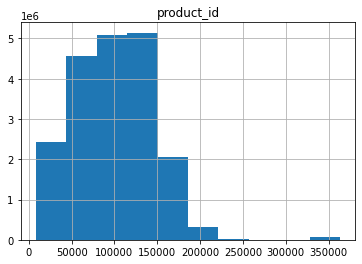

In [16]:
receipts_data.hist(column='product_id')

<AxesSubplot: >

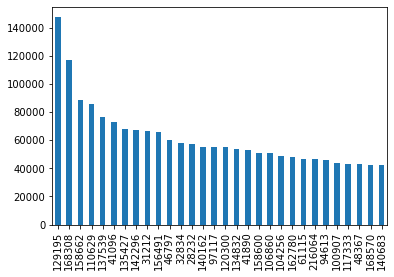

In [17]:
receipts_data['product_id'].value_counts()[:30].plot(kind='bar')

In [18]:
for product_id in receipts_data['product_id'].value_counts()[:10].index:
    print(str(product_id) + data_reader.get_product_description_by_id(product_id))
    print("=====================================================================")

129195(48791) Свободная сумма НДС18% (служебный) -1
168308(197312) Пакет-майка 25см х 45см 906
158662(181542) Карта Забота о Здоровье 855
110629(57733) Корвалол капли д/приема внутрь 25мл 738
137539(117825) Панангин таб.п.п.о.№50 738
41096(81509) PL Хлоргексидин биглюконат р-р 0.05% фл.100мл №1 (НДС 18%) 404
135427(20116) Тауфон капли глазн 4% фл 10 мл. пласт. флак.-кап. 575
142296(70458) Пенталгин таб.п.п.о.№24 (без кодеина) 397
31212(118125) Кардиомагнил таб.п.п.о.75мг №100 738
156491(180739) Омепразол-Акрихин капс.кишечнораст.20мг №30 595


Первые три позиции из данного списка можно удалить. Карту и пакеты можно рекомендовать всегда независимо
от того, что приобрел покупатель. 
Также следует отфильтровать все позиции, относящиеся к категории **служебный**.
Однако такой категории нет в базе данный. 

In [26]:
receipts_data.loc[receipts_data['product_id'] == 129195].head(1)

,sale_date_date,contact_id,shop_id,product_id,name,product_sub_category_id,product_category_id,brand_id,quantity
4776837,2018-01-05,1393270,1505,129195,(48791) Свободная сумма НДС18% (служебный),-1,-1,-1,1


array([[<AxesSubplot: title={'center': 'product_category_id'}>]],
      dtype=object)

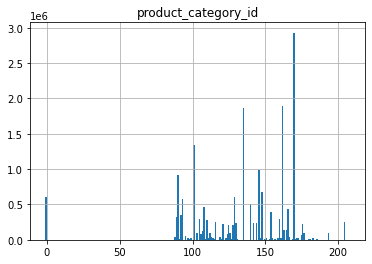

In [31]:
receipts_data.hist(column='product_category_id', bins = 210)

Поэтому отфильтруем все позиции, у которых категория, субкатегория и бренд неизвестны.

In [235]:
filtered_receipts_data = receipts_data.loc[~((receipts_data['product_category_id'] == -1) | 
                                           (receipts_data['product_sub_category_id'] == -1))]

Проверим также не остались ли данные, что содержат слово **служебный**, **Пакет** или **карта** в описании:

In [236]:
products_description[products_description.apply(lambda x : "служебный" in x['product'], axis=1)]

,product_id,product
21047,129195,(48791) Свободная сумма НДС18% (служебный) -1
23926,129484,(26163) Свободная сумма НДС10% (служебный) -1


In [237]:
products_description[products_description.apply(lambda x : "Пакет" in x['product'], axis=1)]

,product_id,product
0,168308,(197312) Пакет-майка 25см х 45см 906
3,168570,(197309) Пакет 28см х 50см 906
4,146960,"(111023) Пакет ""Аптека Озерки"" 28 х 35см 906"
7,94270,"(66684) Пакет майка ""Благодарим за покупку"" (2..."
195,168319,(197310) Пакет 30см х 60см 906
...,...,...
28007,214210,(200068) Пакет упак.прозр.с голографич.рисунко...
29787,111189,(36839) Пакет перевяз. индив. стерильный -1
29905,165941,(194129) ПП Пакет 25 х 30см 906
29955,91825,"(17671) Пакет перевяз. 1 подушечка, эластичный..."


In [238]:
products_description[products_description.apply(lambda x : "Карта" in x['product'], axis=1)]

,product_id,product
5360,158662,(181542) Карта Забота о Здоровье 855
7972,136570,(64791) Карталин защитно-профилактическое сред...
9383,349778,(209964) Карта бонусная Я буду жить 100лет ПРО...
24631,218387,(20016673809) Картамус -1


In [239]:
bags_ids = set([168308, 168570, 146960, 94270, 168319, 31222,  22832, 105675, 164928, 62164, 122035, 107261, 105192, 56633, 216807,  90961, 160777, 160785, 100851, 153121,  57815, 160496,  73424, 350140,  85927,  53949,  26647,
168280,  41489, 339113, 161366, 156035, 156034,  45627,  91501, 358775, 166825, 216816, 107898, 214400, 358718, 
118208,  94155, 168471, 234857, 234856, 117406, 222884, 222902,  76673, 138589, 358733, 222711,
339112, 214838, 217227, 217210, 217393, 218087, 108024,  84067, 142381, 214210, 165941, 96059])

In [240]:
cards_ids = [218194, 158662, 349778]

In [241]:
filtered_receipts_data.loc[filtered_receipts_data['product_id'].isin(bags_ids)]

,sale_date_date,contact_id,shop_id,product_id,name,product_sub_category_id,product_category_id,brand_id,quantity
0,2018-12-07,1260627,1455,168308,(197312) Пакет-майка 25см х 45см,906,205,-1,1
3,2018-12-07,1285774,1511,168570,(197309) Пакет 28см х 50см,906,205,-1,1
4,2018-12-07,1810323,1501,168319,(197310) Пакет 30см х 60см,906,205,-1,1
6,2018-12-07,1697532,1504,168570,(197309) Пакет 28см х 50см,906,205,-1,1
7,2018-12-07,1779333,1455,168308,(197312) Пакет-майка 25см х 45см,906,205,-1,1
...,...,...,...,...,...,...,...,...,...
19991304,2018-06-12,2009452,1455,217393,(200394) Пакет-майка 40см х 70см,906,205,-1,1
19991307,2018-06-12,1716384,1455,217393,(200394) Пакет-майка 40см х 70см,906,205,-1,1
19991332,2018-06-13,1550399,1485,217210,(200396) Пакет Оптика 20см х 30см,906,205,-1,1
19991337,2018-06-13,1874346,1508,217210,(200396) Пакет Оптика 20см х 30см,906,205,-1,1


In [242]:
# Удалим пакеты

filtered_receipts_data = filtered_receipts_data.loc[~(filtered_receipts_data['product_category_id'].isin([205]))]

In [243]:
# Удалим карты

filtered_receipts_data = filtered_receipts_data.loc[~(filtered_receipts_data['product_id'].isin(cards_ids))]

In [244]:
filtered_receipts_data.shape

(18743126, 9)

In [245]:
filtered_receipts_data.head(10)

,sale_date_date,contact_id,shop_id,product_id,name,product_sub_category_id,product_category_id,brand_id,quantity
1,2018-12-07,198287,279,134832,(62448) Перекись водорода р-р наружн. 3% фл.по...,404,93,-1,1
2,2018-12-07,2418385,848,101384,(72183) Салициловая кислота р-р спирт 2% фл 40...,404,93,-1,1
5,2018-12-07,2435604,66,37505,(53208) Кеппра таб.п.п.о.500мг №30,641,146,-1,1
8,2018-12-07,507339,275,134832,(62448) Перекись водорода р-р наружн. 3% фл.по...,404,93,-1,1
17,2018-12-08,514490,350,128700,(51806) Ранитидин тб 150мг уп N20,595,135,-1,2
19,2018-12-08,2109210,324,52539,"(19416) Платки носовые ""Зева Кидс"" №10",721,167,3421,2
21,2018-12-08,2742478,105,77426,"(5605) Иглы Микро-Файн д/шприц-ручки 30G 0,3*8...",759,176,2101,0
23,2018-12-08,87961,596,92475,(114214) Дорзопт капли глазные 2% 5мл. фл.-кап...,575,129,-1,0
25,2018-12-08,2650603,840,158643,(181230) PL Шприц одноразовый 3-комп. 3мл №1,762,176,1520,2
26,2018-12-08,2605787,457,158600,(181232) PL Шприц одноразовый 3-комп. 5мл №1,762,176,1520,20


## Визуализируем чеки

---

Предположим, что один чек -  все что купил покупатель в один день, не зависимо от ``shop_id``

In [136]:
receipts = filtered_receipts_data.groupby(['sale_date_date', 'contact_id']).count()

In [137]:
receipts.head(5)

shop_id  product_id  name  product_sub_category_id  \
sale_date_date contact_id                                                       
2018-01-01     399               5           5     5                        5   
               1631              3           3     3                        3   
               1864              8           8     8                        8   
               1925              5           5     5                        5   
               2397              2           2     2                        2   

                           product_category_id  brand_id  quantity  
sale_date_date contact_id                                           
2018-01-01     399                           5         5         5  
               1631                          3         3         3  
               1864                          8         8         8  
               1925                          5         5         5  
               2397                          2         2         2

### Анализ чеков

---

In [141]:
filtered_receipts_data[(filtered_receipts_data['contact_id']==1925) &
                       (filtered_receipts_data['sale_date_date']=='2018-01-01')]

,sale_date_date,contact_id,shop_id,product_id,name,product_sub_category_id,product_category_id,brand_id,quantity
4690750,2018-01-01,1925,276,153033,"(120911) Презерватив ""Контекс"" Лайтс №30",692,161,3657,1
4704395,2018-01-01,1925,276,139733,(114891) Натрия хлорид 0.9% р-р д/инфуз фл 400...,720,166,-1,1
4712022,2018-01-01,1925,276,136478,(34304) Канефрон Н таб.п.о.N60,628,144,-1,1
4725461,2018-01-01,1925,276,124706,(71661) Гель-смазка Contex Силк 100мл,694,161,3657,1
4744658,2018-01-01,1925,276,92583,(96947) Бел Беби вкладыши для бюстгалтера №30,798,180,2739,1


Посмотрим чеки одного пользователя в разные даты

In [143]:
filtered_receipts_data[(filtered_receipts_data['contact_id']==1864) &
                       (filtered_receipts_data['sale_date_date']=='2018-01-01')]

,sale_date_date,contact_id,shop_id,product_id,name,product_sub_category_id,product_category_id,brand_id,quantity
4696835,2018-01-01,1864,277,103459,"(112473) Фиточай Уротранзит почечный 1,5г №20",628,144,-1,1
4701024,2018-01-01,1864,277,18257,(97629) Урсодез капс. 250мг №100,596,135,-1,1
4704305,2018-01-01,1864,277,114795,(39858) Виферон 3 свечи 1000000МЕ бл N10,705,162,-1,1
4712031,2018-01-01,1864,277,111730,(39856) Виферон 1 свечи 150000МЕ бл N10,577,130,-1,1
4725491,2018-01-01,1864,277,28556,(49167) Бифидумбактерин капс. 5дз N20,600,135,-1,1
4801034,2018-01-01,1864,277,75972,"(97535) Риностоп спрей наз. 0,1% фл. 15мл",701,162,-1,2
4806124,2018-01-01,1864,277,155971,(179763) PL Маска медицинская №5,711,165,1520,3
4810487,2018-01-01,1864,277,122392,(76407) Урдокса капс. 250мг №100,596,135,-1,4


In [144]:
filtered_receipts_data[(filtered_receipts_data['contact_id']==1864) &
                       (filtered_receipts_data['sale_date_date']=='2018-03-23')]   

,sale_date_date,contact_id,shop_id,product_id,name,product_sub_category_id,product_category_id,brand_id,quantity
10273666,2018-03-23,1864,277,137662,(62613) Пирацетам тб п/о 200мг N60,638,146,-1,5
10273693,2018-03-23,1864,277,72789,(41586) Аскорбиновая кислота драже 50мг N200,438,101,-1,4
10273989,2018-03-23,1864,277,35255,(14937) Цианокобаламин р-р д/и 500мкг амп 1мл N10,441,101,-1,2
10400867,2018-03-23,1864,277,160846,(184272) Фолацин таб. 5мг №30,438,101,-1,1
10506788,2018-03-23,1864,277,75972,"(97535) Риностоп спрей наз. 0,1% фл. 15мл",701,162,-1,2
10511509,2018-03-23,1864,277,126636,(24255) Линдинет 20 табл. п.о. №63,450,105,-1,1


In [145]:
filtered_receipts_data[(filtered_receipts_data['contact_id']==1864) &
                       (filtered_receipts_data['sale_date_date']=='2018-06-12')]

,sale_date_date,contact_id,shop_id,product_id,name,product_sub_category_id,product_category_id,brand_id,quantity
17195705,2018-06-12,1864,277,139733,(114891) Натрия хлорид 0.9% р-р д/инфуз фл 400...,720,166,-1,1
17199952,2018-06-12,1864,277,51859,(41229) Амоксиклав таб.п.п.о.500мг+125мг №15,403,92,-1,2
17200055,2018-06-12,1864,277,63026,(43476) Тантум верде аэроз дозир фл 30мл N1,699,162,-1,2
17213882,2018-06-12,1864,277,49966,(71695) Циновит шампунь п/перхоти 150мл,476,112,1273,1


## Выбор подхода для построения рекомендации

---

### Рекомендации товаров из истории покупателя

---


Первым шагом оценим насколько история пользователя влияет на последующие покупки

In [167]:
contacts = filtered_receipts_data['contact_id'].unique()
len(contacts)

1635321

In [196]:
import random 

one_user_data = []
tested_users = []
users_to_test = 10000

for contact in random.choices(contacts, k=users_to_test):
    tested_users.append(contact)
    one_user_data.append(filtered_receipts_data[(filtered_receipts_data['contact_id']==contact)].groupby(['product_id'])['sale_date_date'].count().values)

In [208]:
maxs = [data.max() for data in one_user_data]

gte_count = 0
for value in maxs:
    if value >= 2:
        gte_count += 1

print(gte_count / users_to_test)

0.3525


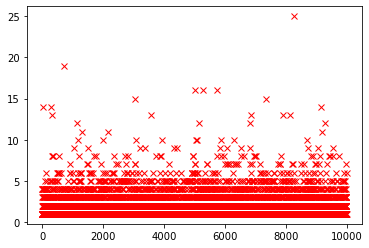

In [193]:
%matplotlib inline
import matplotlib.pyplot as plt

fig = plt.figure()
ax = plt.axes()
ax.plot(maxs, 'xr')

Из данных визуализированных в предыдущей ячейке мы видим, что 35% покупателей берут хотя
бы раз купленный товар повторно.<br/><br/>

Поэтому в список рекомендаций имеет смысл добавить **самый часто покупаемый товар из истории пользователя**.
Если данный товар уже присутствует в чеке, то следующий за ним.
Если пользователь на данный момент не имеет истории, то будет предложен **самый популярный товар за прошедшую неделю**.

In [212]:
filtered_receipts_data[(filtered_receipts_data['contact_id']==962137)]['product_id'].value_counts()

79210     25
97117     10
156136     8
51228      8
114395     7
          ..
87443      1
88564      1
120626     1
52287      1
37089      1
Name: product_id, Length: 641, dtype: int64

In [224]:
print(data_reader.get_product_description_by_id(79210))
print(data_reader.get_product_description_by_id(97117))
print(data_reader.get_product_description_by_id(156136))

(72926) Герботон настойка 70% 100мл 440
(41297) Цитрамон П таб.№10 397
(180238) PL Бахилы медицинские №10 (5 пар) 414


### Рекомендации товаров из схожей категории (контентный метод)

---

В качестве следующего подхода рассмотрим контентный метод.
Однако использовать будем не название продукта, а его категорию и субкатегорию.

In [247]:
categories = filtered_receipts_data['product_category_id'].unique()
print(len(categories))

110


In [250]:
filtered_receipts_data.groupby(['product_category_id'])['contact_id'].count().values

array([  34087,  322222,  911500,   16321,  355662,  583013,    1522,
         60592,     296,   31675,    8451,   19933, 1344151,    1114,
         92945,     689,  289235,   82669,  120405,  470395,   18146,
        285921,   22480,   93577,   42156,   18721,   14740,  250706,
           586,    2427,   38056,   15720,  219106,     821,   26923,
         87886,  213376,   97935,    9904,  210294,  604012,  239433,
          8154,      41,      51, 1864475,    3431,      24,      10,
           305,  503218,    2338,  242757,      18,  242576,       4,
        987559,   20081,  680720,       5,    5346,   29247,    3109,
         15417,  394514,   23247,    4184,    9204,   25756,  298636,
         30161, 1889522,  138517,  135042,  429972,   46075,     680,
          7362, 2930402,   17370,   19353,   23292,   69109,  225875,
         90116,     860,    3413,    9673,    4276,    3799,   24581,
             8,     581,    8710,      53,      45,     295,      59,
           151,     

У нас имеется 110 различных категорий товаров. Некоторые категории включают в себя более 100 тысяч товаров.

In [251]:
filtered_receipts_data[(filtered_receipts_data['contact_id']==962137) &
                       (filtered_receipts_data['sale_date_date']=='2018-04-28')]

,sale_date_date,contact_id,shop_id,product_id,name,product_sub_category_id,product_category_id,brand_id,quantity
11342703,2018-04-28,962137,453,162832,(185573) Минки Ватные диски №100,726,167,2197,1
11343359,2018-04-28,962137,453,65041,(114497) Доктор Йод раствор антисептический фл...,400,91,1520,1
11343502,2018-04-28,962137,453,126028,(51821) Флюкостат капс 150мг N1,622,142,-1,1
11343833,2018-04-28,962137,453,146983,(42024) Лимфомиозот капли внутр фл-капел 30мл N1,456,107,-1,1
11344769,2018-04-28,962137,453,116399,(79474) Максилак капс. №10,597,135,-1,1
11347503,2018-04-28,962137,453,144179,(105064) Ксефокам таб.п.п.о. 8мг №10,647,148,-1,1
11349446,2018-04-28,962137,453,65123,(88544) Систейн гл. капли 15 мл.,575,129,-1,1
11349470,2018-04-28,962137,453,57158,(43700) Артрозилен р-р в/в и в/м 80мг/мл амп. ...,397,90,-1,1
11353419,2018-04-28,962137,453,154002,(122521) Нейромультивит р-р д/инъек. амп. 2мл №10,438,101,-1,1
11353471,2018-04-28,962137,453,117000,(36354) Борная кислота р-р спирт 3% фл 25мл N1,404,93,-1,1


<AxesSubplot: >

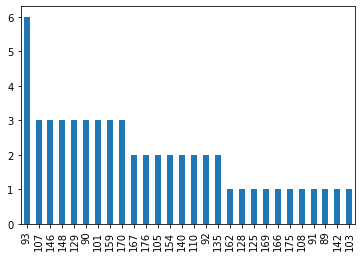

In [252]:
filtered_receipts_data[(filtered_receipts_data['contact_id']==962137) &
                       (filtered_receipts_data['sale_date_date']=='2018-04-28')]['product_category_id'].value_counts().plot(kind='bar')

In [232]:
filtered_receipts_data[(filtered_receipts_data['contact_id']==962137) &
                       (filtered_receipts_data['sale_date_date']=='2018-04-28') &
                       (filtered_receipts_data['product_category_id']==93)]['product_sub_category_id']

11353471    404
11359279    404
11380533    404
11381250    404
14378675    404
14387739    404
Name: product_sub_category_id, dtype: int32

Товар из категории 93 и субкатегории 404 чаще всего встречается в чеке пользователя *962137*.
Под данные критерии подходят более полумиллиона товаров.<br/>

Примеры товаров из чека:
* Холисал гель стоматологический туба 
* Борная кислота р-р спирт
* Перекись водорода р-р наружн. 3%
* Хлоргексидин биглюконат р-р 0.05%

Анализ названий с помощью поиска похожих эмбеддингов также не даст хороших результатов в связи с тем,
что названия схожих препаратов отличаются семантически.

In [233]:
filtered_receipts_data[(filtered_receipts_data['product_sub_category_id']==404) &
                       (filtered_receipts_data['product_category_id']==93)]

,sale_date_date,contact_id,shop_id,product_id,name,product_sub_category_id,product_category_id,brand_id,quantity
1,2018-12-07,198287,279,134832,(62448) Перекись водорода р-р наружн. 3% фл.по...,404,93,-1,1
2,2018-12-07,2418385,848,101384,(72183) Салициловая кислота р-р спирт 2% фл 40...,404,93,-1,1
8,2018-12-07,507339,275,134832,(62448) Перекись водорода р-р наружн. 3% фл.по...,404,93,-1,1
34,2018-12-08,258137,316,39811,(116543) PL Салфетка антисептическая спиртовая...,404,93,1520,12
36,2018-12-08,1190940,363,25965,(112660) Калия перманганат пор фл 5г N1,404,93,-1,2
...,...,...,...,...,...,...,...,...,...
19999498,2018-06-13,1647543,1524,148082,(3366) Салициловая кислота р-р спирт 1% фл 40м...,404,93,-1,1
19999500,2018-06-13,1261272,1508,134832,(62448) Перекись водорода р-р наружн. 3% фл.по...,404,93,-1,1
19999552,2018-06-13,1946624,1506,120084,(44845) Борная кислота р-р спирт 3% фл 25мл N1,404,93,-1,1
19999907,2018-06-13,1670443,1506,28118,(43173) Мирамистин р-р 0.01% фл 500мл N1,404,93,-1,1


### Рекомендации товаров с помощью метода матричной рекомендации

---

Попробуем обучить модель матричной рекомендации SVD из библиотеки surprise.
В качестве item_id будем использовать product_id.

В качестве теста попробуем оценить работу данной модели с помощью кроссвалидации.

In [263]:
# Подготовим данные

user_ids = filtered_receipts_data.contact_id.unique()
user_ids_map = {user_ids[i]: i for i in range(len(user_ids))}

item_ids = filtered_receipts_data.product_id.unique()
item_ids_map = {item_ids[i]: i for i in range(len(item_ids))}

df = pd.DataFrame()
df["user_id"] = filtered_receipts_data["contact_id"].apply(lambda x: user_ids_map[x]) 
df["item_id"] = filtered_receipts_data["product_id"].apply(lambda x: item_ids_map[x]) 
df["rating"] = 1

In [264]:
df.drop_duplicates(inplace=True)

In [265]:
df.shape

(15720023, 3)

In [266]:
df.head(3)

,user_id,item_id,rating
1,0,0,1
2,1,1,1
5,2,2,1


In [267]:
from surprise import Reader
from surprise import Dataset

# The columns must correspond to user id, item id and ratings (in that order).
reader = Reader(rating_scale=(0, 1))
data = Dataset.load_from_df(df[['user_id', 'item_id', 'rating']], reader)

In [268]:
from surprise import SVD
from surprise.model_selection import cross_validate

svd = SVD(verbose=True, n_epochs=30)
cross_validate(svd, data, measures=['RMSE', 'MAE'], cv=3, verbose=True)

Processing epoch 0
Processing epoch 1
Processing epoch 2
Processing epoch 3
Processing epoch 4
Processing epoch 5
Processing epoch 6
Processing epoch 7
Processing epoch 8
Processing epoch 9
Processing epoch 10
Processing epoch 11
Processing epoch 12
Processing epoch 13
Processing epoch 14
Processing epoch 15
Processing epoch 16
Processing epoch 17
Processing epoch 18
Processing epoch 19
Processing epoch 20
Processing epoch 21
Processing epoch 22
Processing epoch 23
Processing epoch 24
Processing epoch 25
Processing epoch 26
Processing epoch 27
Processing epoch 28
Processing epoch 29
Processing epoch 0
Processing epoch 1
Processing epoch 2
Processing epoch 3
Processing epoch 4
Processing epoch 5
Processing epoch 6
Processing epoch 7
Processing epoch 8
Processing epoch 9
Processing epoch 10
Processing epoch 11
Processing epoch 12
Processing epoch 13
Processing epoch 14
Processing epoch 15
Processing epoch 16
Processing epoch 17
Processing epoch 18
Processing epoch 19
Processing epoch 20


{'test_rmse': array([0.01249551, 0.01250162, 0.01246068]),
 'test_mae': array([0.00345629, 0.0034504 , 0.00343833]),
 'fit_time': (185.0127513408661, 186.58281779289246, 186.38504910469055),
 'test_time': (39.98287892341614, 36.15215730667114, 36.6375892162323)}

### Рекомендации товаров с помощью поиска похожих чеков


---

Так как предыдущий метод с использованием конкретных product_id показал очень низкие метрики при кроссвалидации,
можно попробовать искать похожие чеки по product_category_id.

In [383]:
from tqdm import tqdm
tqdm.pandas()

receipts = filtered_receipts_data.groupby(['sale_date_date', 'contact_id']).agg({'product_sub_category_id': lambda x: list(x),
                                                                                  'product_category_id': lambda x: list(x)})

Отфильтруем чеки, которые содержат всего один продукт:

In [404]:
receipts_filtered = receipts[receipts.apply(lambda x: len(x['product_sub_category_id']) > 1, axis=1)]

In [433]:
receipts_filtered.tail(3)

product_sub_category_id  \
sale_date_date contact_id                                        
2018-12-09     2746142                         [397, 397, 555]   
               2746260     [489, 506, 595, 496, 505, 496, 496]   
               2746261                              [696, 595]   

                                           product_category_id  
sale_date_date contact_id                                       
2018-12-09     2746142                           [90, 90, 126]  
               2746260     [114, 116, 135, 116, 116, 116, 116]  
               2746261                              [162, 135]

Составим эмбеддинги
для каждого чека:

In [429]:
receipts_filtered_with_embeddings = receipts_filtered.copy()
receipts_filtered_with_embeddings['distances'] = 0.0
receipts_filtered_with_embeddings['distances'] = receipts_filtered_with_embeddings['product_sub_category_id'].apply(lambda x: 
                                                                                       [val / 1000.0 for val in x])

In [430]:
receipts_filtered_with_embeddings['distances'] = receipts_filtered_with_embeddings.apply(lambda x: 
                                                                                       [sum(val) for val in zip(x['distances'],
                                                                                                                x['product_category_id'])],
                                                                                       axis=1)

In [435]:
receipts_filtered_with_embeddings.head(2)

product_sub_category_id  \
sale_date_date contact_id                              
2018-01-01     399         [705, 648, 701, 703, 705]   
               1631                  [575, 575, 598]   

                                 product_category_id  \
sale_date_date contact_id                              
2018-01-01     399         [162, 148, 162, 162, 162]   
               1631                  [129, 129, 135]   

                                                               distances  
sale_date_date contact_id                                                 
2018-01-01     399         [162.705, 148.648, 162.701, 162.703, 162.705]  
               1631                          [129.575, 129.575, 135.598]

После группировки чеков и их эмбеддингов необходимо решить, как считать "схожесть" чеков.
* Если в чеках присутствуют одинаковые категории, то за каждую категорию добавляем +1 к схожести чеков
* Если же совпадают как категории, так и субкатегории, то +2 за каждое совпадение

**Пример:**

Ищем наиболее близкий чек к:

In [455]:
receipts_filtered_with_embeddings.loc[('2018-01-01', 1631)]

product_sub_category_id                [575, 575, 598]
product_category_id                    [129, 129, 135]
distances                  [129.575, 129.575, 135.598]
Name: (2018-01-01, 1631), dtype: object

In [456]:
filtered_receipts_data.loc[(filtered_receipts_data['sale_date_date'] == '2018-01-01') &
                           (filtered_receipts_data['contact_id'] == 1631)]

,sale_date_date,contact_id,shop_id,product_id,name,product_sub_category_id,product_category_id,brand_id,quantity
4725576,2018-01-01,1631,282,82892,"(86052) Ксалатан капли глазн. 0,005 % фл.-кап....",575,129,-1,1
4806131,2018-01-01,1631,282,76206,(114236) Трусопт капли глазн 2% 5мл фл N1,575,129,-1,3
4809000,2018-01-01,1631,282,79735,(104004) Сенаде тб 13.5мг N500,598,135,-1,0


In [481]:
def find_similar_receipt(df, embeddings_set, product_category_id_set):
    max_similarity_possible = len(embeddings_set) + len(product_category_id_set)
    
    max_similarity = 0
    max_similarity_idx = -1

    for index, row in df.iterrows():
        similarity = len(product_category_id.intersection(set(row['product_category_id'])))
        similarity += len(feature_vector.intersection(set(row['distances'])))
        if similarity > max_similarity:
            max_similarity = similarity
            max_similarity_idx = index
            if max_similarity == max_similarity_possible:
                break
    return max_similarity, max_similarity_idx

In [474]:
# Возьмем первую половину чека:
embeddings_set = set([129.575])#, , 135.598])
product_category_id = set([129])#, 135])

max_similarity, max_similarity_idx = find_similar_receipt(receipts_filtered_with_embeddings[2:], 
                                                          embeddings_set, product_category_id)

In [475]:
max_similarity, max_similarity_idx

(2, ('2018-01-01', 4129))

In [462]:
filtered_receipts_data.loc[(filtered_receipts_data['sale_date_date'] == '2018-01-01') &
                           (filtered_receipts_data['contact_id'] == 4129)]

,sale_date_date,contact_id,shop_id,product_id,name,product_sub_category_id,product_category_id,brand_id,quantity
4704393,2018-01-01,4129,317,111900,"(15531) Визин Классический капли глазн. 0,05 %...",575,129,-1,1
4719472,2018-01-01,4129,317,77732,(106007) Теалоз раствор для защиты глаз увлажн...,575,129,-1,1
4738804,2018-01-01,4129,317,120439,(2270) АЦЦ гран. д/р-ра для приема внутрь 200м...,550,125,-1,1
4744108,2018-01-01,4129,317,33583,(35713) Геломиртол форте капс. 300мг №20,550,125,-1,1


**Рекоммендация**:
АЦЦ гран. и  Геломиртол форте капс. (125.550) 	

**Ожидание**:
Сенаде тб 13.5мг N500 (135.598)

## Деление данных на train и test. Выбор метрик для оценки качества предсказаний.

---

В качестве тестовых данных мы можем взять чеки за последние 2 дня продаж,
которые содержат 2 и более товаров.


Протестируем следующие модели:

1. Товары из наиболее близкого чека на основе всех позиций тестового чека, кроме последней
2. Товары из истории пользователя

Вместо стандартных метрик precision и recall, посчитаем:
Если категория последнего товара из тестируемого чека есть в предложенных категориях.

Данная метрика покажет перспективность данных подходов.

In [494]:
test_data = filtered_receipts_data[(filtered_receipts_data['sale_date_date'] >= '2018-12-08')]

In [495]:
test_data['sale_date_date'].unique()

array(['2018-12-08', '2018-12-09'], dtype=object)

In [496]:
train_data = filtered_receipts_data[(filtered_receipts_data['sale_date_date'] < '2018-12-08')]

In [499]:
receipts_keys = receipts_filtered_with_embeddings.index.values

In [503]:
test_keys = []
train_keys = []

for k in receipts_keys:
    if k[0] in ['2018-12-08', '2018-12-09']:
        test_keys.append(k)
    else:
        train_keys.append(k)

In [505]:
receipts_filtered_with_embeddings_train = receipts_filtered_with_embeddings[receipts_filtered_with_embeddings.index.isin(train_keys)]

In [506]:
receipts_filtered_with_embeddings_test = receipts_filtered_with_embeddings[receipts_filtered_with_embeddings.index.isin(test_keys)]

In [518]:
hit_count = 0

for index, row in receipts_filtered_with_embeddings_test.iterrows():
    history = train_data[(train_data['contact_id'] == index[1])]
    if history.shape[0] > 0:
        target_category = row['product_category_id'][-1]
        if target_category in set(history['product_category_id'].values):
            hit_count += 1

In [519]:
hit_count

15984

In [520]:
receipts_filtered_with_embeddings_test.shape

(31490, 3)

В 15984 чеках из 31490 встречается категория продукта, которую покупатель приобретал
в одно из предыдущих посещений. Однако данный метод требует еще улучшений,
так как мы рекомендуем все возможные категории и при подсчете метрики не учитываем
количество рекоммендаций.

In [ ]:
# Код для проверки попаданий рекомендаций на основе метода схожести чеков.
# В связи в долгой обработкой каждого запроса, вычисления были сделаны только на первых 100 элементах

hit_count = 0

for index, row in receipts_filtered_with_embeddings_test[:100].iterrows():
    try:   
        product_category_ids = row['product_category_id']
        embedings = row['distances']
        _, max_similarity_idx = find_similar_receipt(receipts_filtered_with_embeddings_train,
                                                                  set(embedings[:-1]),
                                                                  set(product_category_ids[:-1]))
        target_category = row['product_category_id'][-1]
        if target_category in set(receipts_filtered_with_embeddings_train.loc[max_similarity_idx]['product_category_id']):
            hit_count += 1
    except KeyError:
        # Receipt is not present in receipts df, since it containes only one item
        continue
        

## Выводы

---

При проведении разведочного анализа данных были сделаны следующие выводы:
1. Покупатели в более чем 35% случаем покупает один из товаров повторно
2. Категории товаров слишком обширные (даже с учетом субкатегорий),
подсчет схожести чеков на данной основе, не дает хороших рекомендаций
3. Метод матричной рекоммендации также показал низкие метрики,
за счет большого множества товаров и отсутствия оценок (0 - нет данных, 1 - купил)



Для написание хорошей рекомендательной системы для аптеки необходимо заполнить собрать больше информации,
таких как
* состав препаратов (искать похожие по действующему веществу)
* группы лекарств, которые принимаются вместе на основании рекомендации врачей (антибиотики и пробиотики, спрей для промывания носа и капли в нос, ...)
* информация о наборах (шампунь данной марки входит в набор с кондиционером и маской)

Также стоит попробовать более сложные рекомендательные системы, основанные на нейронных сетях.